In [1]:
import numpy as np
import random 
from scipy.stats import unitary_group
from scipy.sparse import csr_matrix, kron
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

In [2]:
# defining Pauli matrices & CNOTs
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

CNOT = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]] # control tensor switch
CNOT_12_34 = kron(CNOT, CNOT)

data_13_24 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
row_13_24 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
column_13_24 = np.array([0,1,2,3,5,4,7,6,10,11,8,9,15,14,13,12])
CNOT_13_24 = csr_matrix((data_13_24,(row_13_24,column_13_24)), shape =(16,16))

data_14_23 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
row_14_23 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
column_14_23 = np.array([0,1,2,3,6,7,4,5,9,8,11,10,15,14,13,12])
CNOT_14_23 = csr_matrix((data_14_23,(row_14_23,column_14_23)), shape =(16,16))

# defining rotation gates
def Ry(A):
    M = np.array([[np.cos(A/2),-np.sin(A/2)],[np.sin(A/2), np.cos(A/2)]])
    return M
def Rz(A):
    M = np.array([[np.exp(-1j*A/2),0],[0,np.exp(1j*A/2)]])
    return M
    
# Parameterising the general unitary with rotation gates
def U (A0,A1,A2): # Arguments: Euler Angles
    M = Rz(A1)@Ry(A0)@Rz(A2)
    return M

# derivatives wrt A0,A1,A2
def DA0(A0,A1,A2):
    dA0 = (-1j/2)*(Rz(A1)@Y@Ry(A0)@Rz(A2))
    return dA0
def DA1(A0,A1,A2):
    dA1 = (-1j/2)*(Z@Rz(A1)@Ry(A0)@Rz(A2))
    return dA1
def DA2 (A0,A1,A2):
    dA2 = (-1j/2)*(Rz(A1)@Ry(A0)@Z@Rz(A2))
    return dA2

# defining inverse
def inverse(M):
    M_inverse = M.transpose().conjugate()
    return M_inverse
    
def parameters(layers): # layers = number of unitary layers, so no-of CNOTs = layers - 1
    A = np.zeros((4*layers,3))
    for i in range(4*layers):
        for j in range(3):
            A[i][j] = random.uniform(0.0, 4*np.pi) 
    return A
    
def Ulist(layers,A):
    U_list=[]
    for i in range(4*layers):
        Ui = U(A[i][0],A[i][1],A[i][2])
        U_list.append(Ui)
    return U_list

In [3]:
def circuit_structure(A,layers, j, U_goal): # qubit number
    U_list= Ulist(layers,A)
    CNOTS = [CNOT_12_34,CNOT_13_24,CNOT_14_23]
    U_list[j-1] = np.eye(2)  # isolating unitary of interest
    U_kron =[]
    for i in range(0,4*layers,4):
        elt1 = np.kron(U_list[i],U_list[i+1])
        elt2 = np.kron(U_list[i+2],U_list[i+3])
        elt = np.kron(elt1,elt2)
        U_kron.append(elt)
    U_kron = np.array(U_kron)
    q = (j-1) // 4
    Uf = np.eye(16)
    Ub = np.eye(16)
    for it in range(q):
        #print(it)
        Uf = Uf @ U_kron[it] @ CNOTS[it%3]
    #print(q)
    Uf = Uf @ U_kron[q]
    for ib in range(q+1, layers):
        Ub = Ub@ CNOTS[(ib-1)%3] @ U_kron[ib]
    U_tbm = inverse(Uf)@U_goal@inverse(Ub) # U_tbm = rhs , U to be made
    return U_tbm


In [4]:
def gradient_descent(layers,U_goal, A, iterations, alpha):
    nsu = 4*layers #(number of single qubit unitaries)
    inner_iterations = int(iterations/10)
    #print(inner_iterations)
    stop_flag=0
    Aopt = np.copy(A) # to separate input and output
    Uerr_array =[]
    for i in range(inner_iterations):
        if i%10==0:
            print("iteration",i)
        if stop_flag ==1:
            print("Truncation")
            break
        for j in range(1, nsu + 1):
            #print("j =",j)
            # rhs of the optimisation
            Ui = circuit_structure(Aopt, layers, j, U_goal)
             # defining LHS
            A0=Aopt[j-1][0]
            A1=Aopt[j-1][1]
            A2=Aopt[j-1][2]
        
            U_initial= U(A0,A1,A2)
            if j%4 == 1:
                U12 = np.kron(U_initial,np.eye(2))
                U34 = np.eye(4)
                Uxyz = np.kron(U12,U34)
            elif j%4 == 2:
                U12 = np.kron(np.eye(2),U_initial)
                U34 = np.eye(4)
                Uxyz = np.kron(U12,U34)
            elif j%4 == 3:
                U12 = np.eye(4)
                U34 =np.kron(U_initial, np.eye(2))
                Uxyz = np.kron(U12,U34)
            elif j%4 == 0 :
                U12 = np.eye(4)
                U34 =np.kron(np.eye(2),U_initial)
                Uxyz = np.kron(U12,U34)
            for k in range(10): # outer iterations
             #defining cost function
                Tr = np.trace(Ui@inverse(Uxyz))
                Abs = np.abs(Tr)
                Uerr = 16 - Abs
                Uerr_array.append(Uerr)
                #print(Uerr)
                if Uerr < 1e-8:
                    stop_flag=1
                    break
                else:
                    #gradient 
                    dA0 = DA0(A0,A1,A2)
                    dA1 = DA1(A0,A1,A2)
                    dA2 = DA2(A0,A1,A2)
                if j%4 == 1:
                    UdA0 = np.kron(np.kron(dA0,np.eye(2)), np.eye(4))
                    UdA1 = np.kron(np.kron(dA1,np.eye(2)), np.eye(4))
                    UdA2 = np.kron(np.kron(dA2,np.eye(2)), np.eye(4))
                elif j%4 == 2:
                    UdA0 = np.kron(np.kron(np.eye(2),dA0), np.eye(4))
                    UdA1 = np.kron(np.kron(np.eye(2),dA1), np.eye(4))
                    UdA2 = np.kron(np.kron(np.eye(2),dA2), np.eye(4))
            
                elif j%4 == 3:
                    UdA0 =np.kron(np.eye(4),np.kron(dA0, np.eye(2)))
                    UdA1 =np.kron(np.eye(4),np.kron(dA1, np.eye(2)))
                    UdA2 =np.kron(np.eye(4),np.kron(dA2, np.eye(2)))
                elif j%4 == 0 :
                    UdA0 =np.kron(np.eye(4),np.kron(np.eye(2),dA0))
                    UdA1 =np.kron(np.eye(4),np.kron(np.eye(2),dA1))
                    UdA2 =np.kron(np.eye(4),np.kron(np.eye(2),dA2))
                Grad_A0 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA0)))
                Grad_A0R = Grad_A0.real
                Grad_A1 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA1)))
                Grad_A1R = Grad_A1.real
                Grad_A2 = -np.conj((Tr/Abs))*(np.trace(Ui@inverse(UdA2)))
                Grad_A2R = Grad_A2.real
        
                #updation
                A0 = A0 - alpha*Grad_A0R
                A1 = A1 - alpha*Grad_A1R
                A2 = A2 - alpha*Grad_A2R
                if j%4 == 1:
                    U12 = np.kron(U(A0,A1,A2),np.eye(2))
                    U34 = np.eye(4)
                    Uxyz = np.kron(U12,U34)
                elif j%4 == 2:
                    U12 = np.kron(np.eye(2),U(A0,A1,A2))
                    U34 = np.eye(4)
                    Uxyz = np.kron(U12,U34)
                elif j%4 == 3:
                    U12 = np.eye(4)
                    U34 =np.kron(U(A0,A1,A2), np.eye(2))
                    Uxyz = np.kron(U12,U34)
                elif j%4 == 0 :
                    U12 = np.eye(4)
                    U34 =np.kron(np.eye(2),U(A0,A1,A2))
                    Uxyz = np.kron(U12,U34)
                Aopt[j-1][0]=A0
                Aopt[j-1][1]=A1
                Aopt[j-1][2]=A2
                if stop_flag==1:
                    break
    return Uerr_array
        #return Aopt, stop_flag
                
           
    

In [18]:
layers = 35
U_goal = (unitary_group.rvs(16))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)

Uerr = gradient_descent(layers,U_goal, AOpt, 25000, 0.1)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite

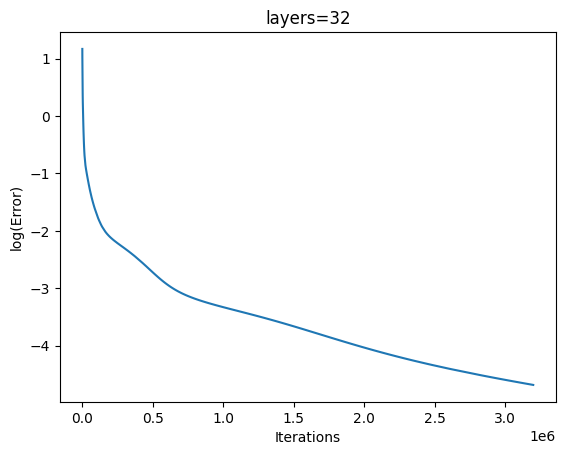

In [19]:
plt.plot(np.log10(Uerr))
plt.title("layers="+str(layers))
plt.xlabel("Iterations")
plt.ylabel("log(Error)")
plt.savefig('4 qubit system layers 32 1.png', bbox_inches='tight')

## Same Unitary- 5 initialisations - 35 layers

In [6]:
layers = 35
U_goal = (unitary_group.rvs(16))
#print(U_goal)
for h in range(5):
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Initialisation:", h+1)
    Uerr = gradient_descent(layers,U_goal, AOpt, 25000, 0.1)
    print("\nIterations:",len(Uerr))
    plt.plot(np.log10(Uerr))
    plt.title("Initialisation "+str(h+1))
    plt.savefig("Initialisation "+str(h+1))
    plt.close()
    

Initialisation: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
Truncation

I

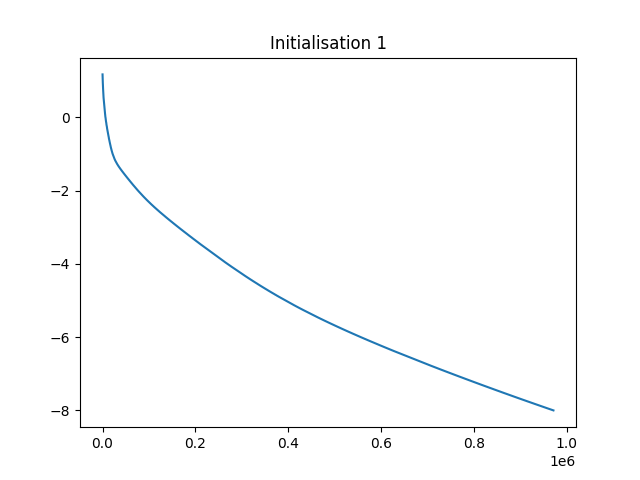

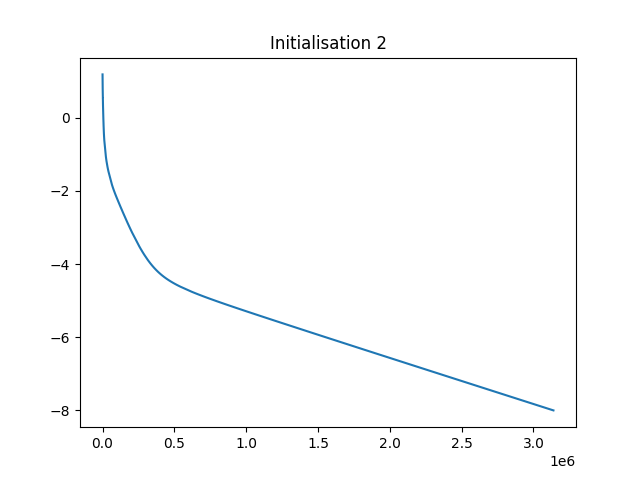

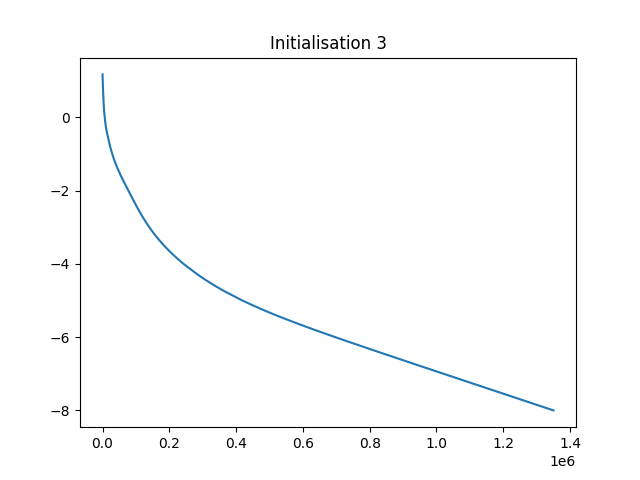

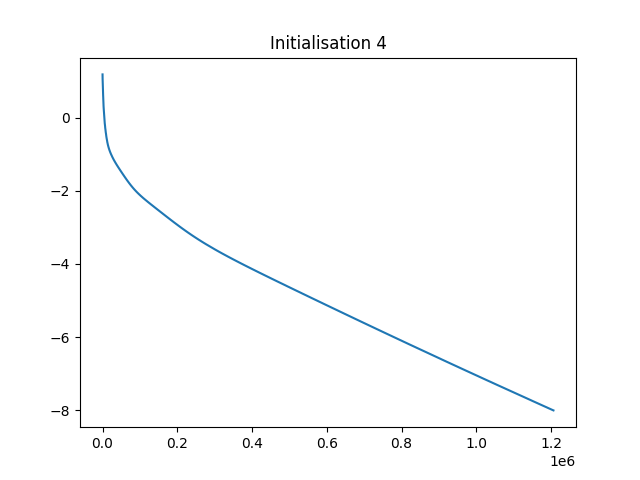

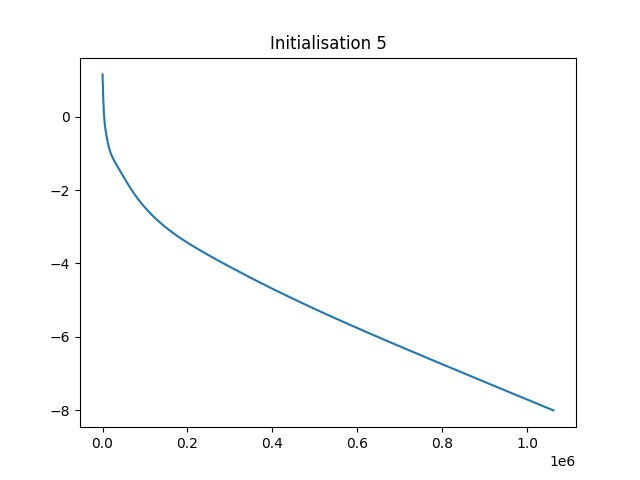

In [7]:
img11 = Image.open("Initialisation 1.png") 
img22 = Image.open("Initialisation 2.png")  
img33 = Image.open("Initialisation 3.png")  
img44 = Image.open("Initialisation 4.png")  
img55 = Image.open("Initialisation 5.png")  # Replace with your filename
display(img11,img22,img33,img44,img55)

In [8]:
U_goal_list = []
for h in range(5):
    elt = unitary_group.rvs(16)
    U_goal_list.append(elt)

    

### 5 Different Unitaries

In [10]:
for k in range(5):
    U_goal = U_goal_list[k]
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Unitary:", k+1)
    Uerr = gradient_descent(layers,U_goal, AOpt, 25000, 0.1)
    print("\nIterations:",len(Uerr))
    plt.plot(np.log10(Uerr))
    plt.title("Unitary "+str(k+1))
    plt.savefig("Unitary "+str(k+1))
    plt.close()

Unitary: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iterat

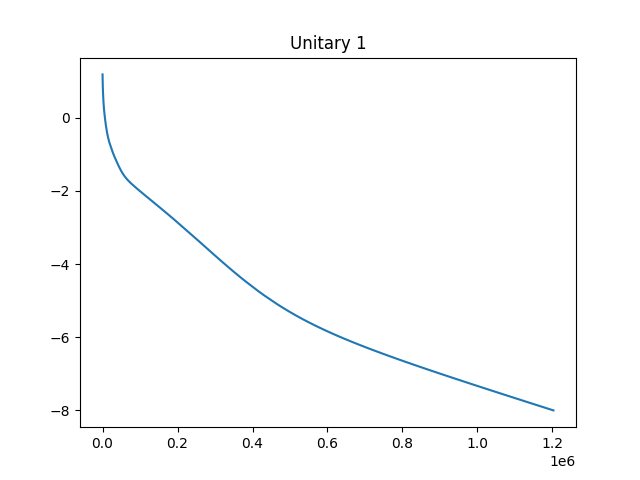

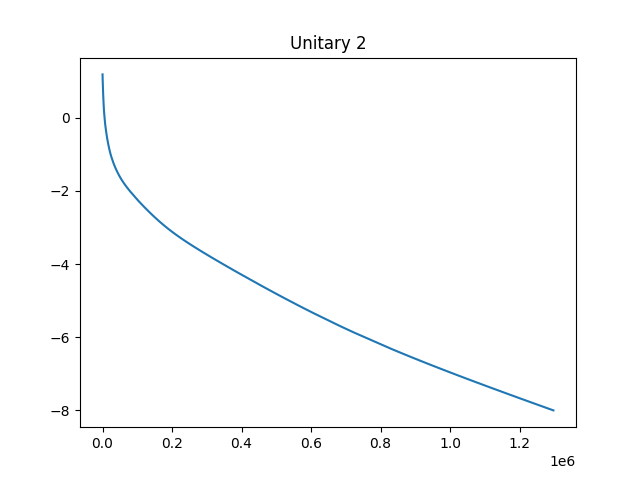

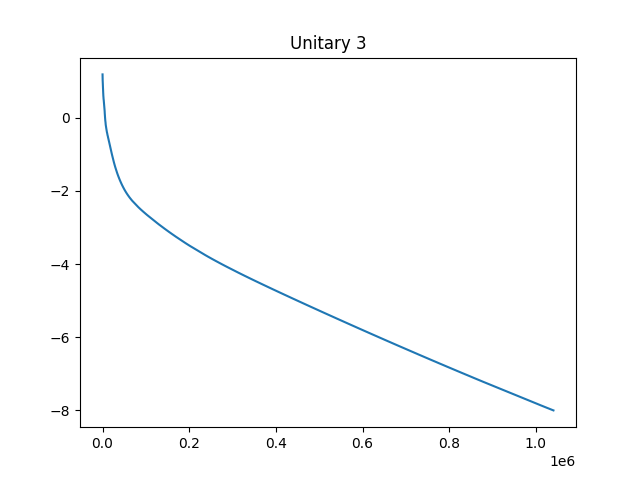

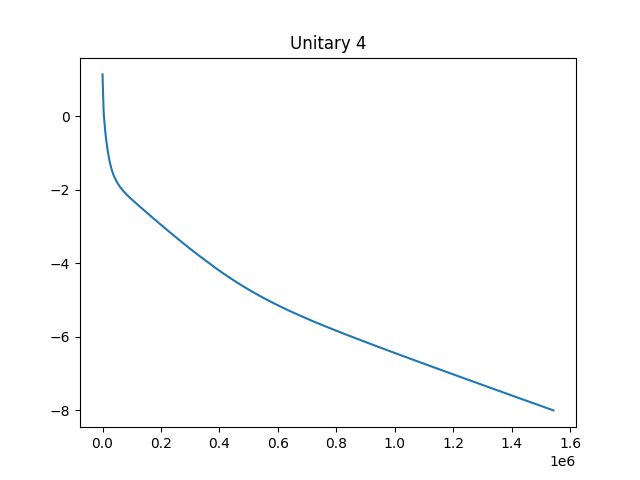

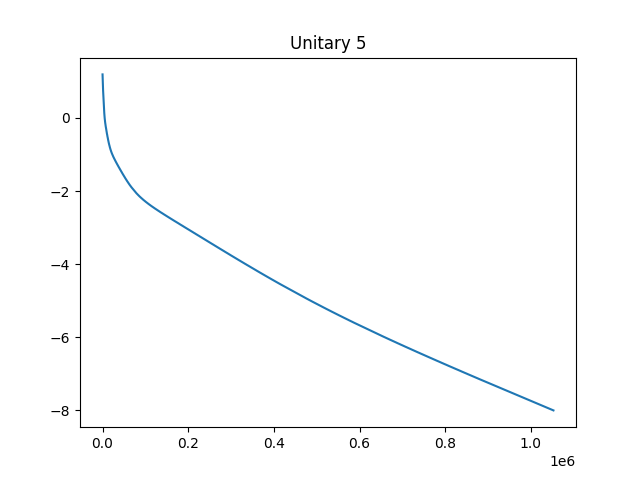

In [11]:

img1 = Image.open("Unitary 1.png") 
img2 = Image.open("Unitary 2.png")  
img3 = Image.open("Unitary 3.png")  
img4 = Image.open("Unitary 4.png")  
img5 = Image.open("Unitary 5.png")  # Replace with your filename
display(img1,img2,img3,img4,img5)

### Same Unitary, Same initialisation, different number of layers


In [20]:
layers_list = [32,35,40,50]
U_goal = (unitary_group.rvs(16))
#print(U_goal)
for h in range(4):
    A = parameters(layers_list[h])
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Layers = ", layers_list[h])
    Uerr = gradient_descent(layers_list[h],U_goal, AOpt, 20000, 0.1)
    print("\nIterations:",len(Uerr))
    plt.plot(np.log10(Uerr))
    plt.title("Number of layers "+str(layers_list[h]))
    plt.xlabel("Iterations")
    plt.ylabel("Log(Error)")
    plt.savefig("Number of layers "+str(layers_list[h]))
    plt.close()

Layers =  32
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iter

In [24]:
rqd_unitary = U_goal
print(U_goal)

[[-1.86098603e-01-0.07462713j  1.44862544e-01+0.48297472j
  -2.06203872e-01-0.00673139j  1.42993200e-01+0.2622163j
   1.29663802e-01-0.08123809j  1.65418329e-01-0.02966338j
   7.64945043e-02-0.20482901j  2.48744412e-01+0.11032917j
  -6.67904240e-02+0.11327312j -3.33096195e-02-0.09441315j
   2.00787099e-01+0.22575372j  2.35065878e-01-0.22831668j
  -1.13766352e-01-0.27381346j  9.72734265e-02-0.07791232j
  -1.33221958e-01+0.17438168j  1.49349597e-01-0.01947434j]
 [-1.45067517e-01-0.13855722j -7.39797245e-03-0.08783631j
  -7.40348728e-02-0.18011342j -3.48990962e-01-0.0596907j
   2.26946464e-01-0.54177801j  3.20943117e-01-0.14317667j
   2.17361580e-02+0.0568037j   3.67682643e-02-0.0557127j
   1.86122640e-02+0.13102057j -1.41495469e-01-0.13681175j
  -2.83248542e-02-0.00864653j -3.09666796e-01+0.11494999j
  -1.11792148e-01+0.16177497j  2.30978175e-01+0.10681639j
  -1.06309145e-01+0.08888918j -1.61081863e-02+0.15130635j]
 [-8.95017135e-02-0.0569103j   2.45243805e-01+0.23293714j
   5.15931576e-

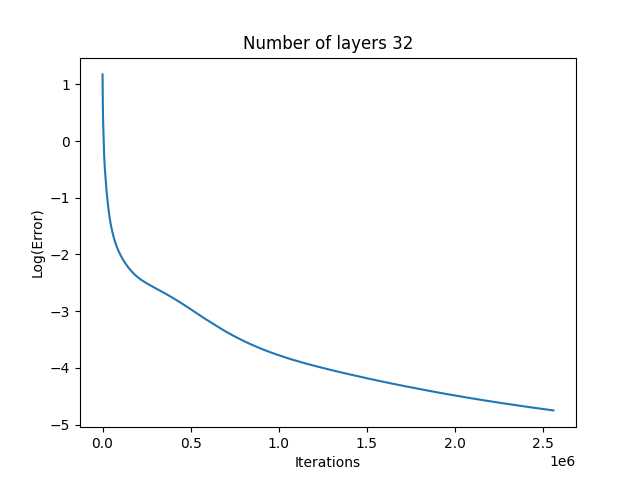

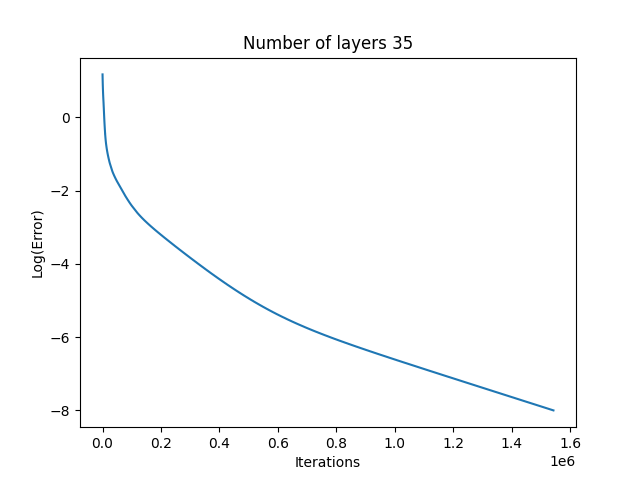

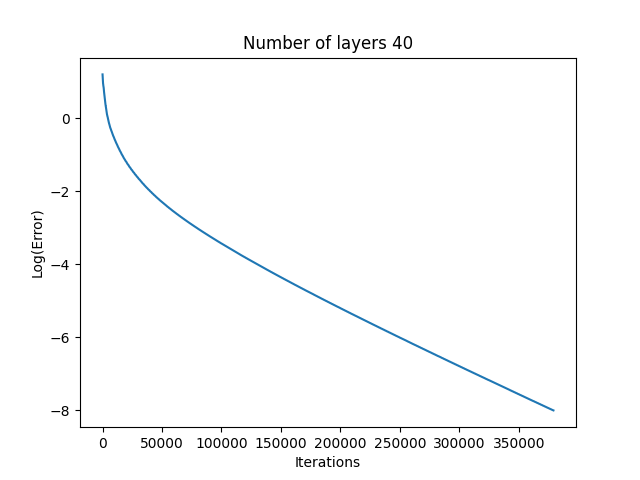

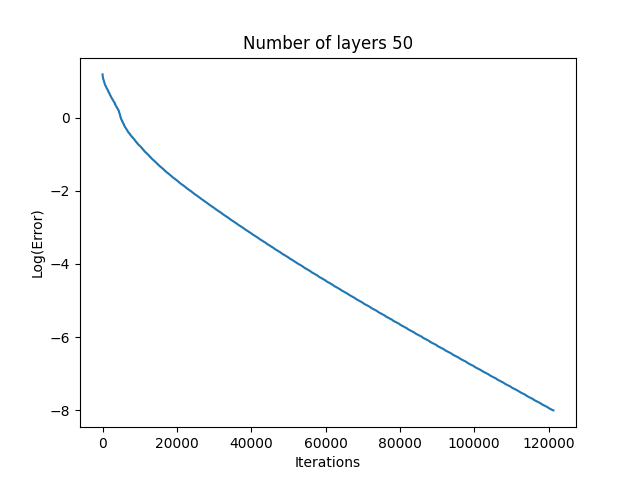

In [21]:
img111 = Image.open("Number of layers 32.png") 
img222 = Image.open("Number of layers 35.png")  
img333 = Image.open("Number of layers 40.png")  
img444 = Image.open("Number of layers 50.png")  
  # Replace with your filename
display(img111,img222, img333, img444)